<a href="https://colab.research.google.com/github/abhiyantaabhishek/COVID_19_Detection/blob/master/COVID_19_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169


In [3]:
!git clone https://github.com/abhiyantaabhishek/COVID_19_Detection
%cd COVID_19_Detection

Cloning into 'COVID_19_Detection'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 762 (delta 2), reused 0 (delta 0), pack-reused 750
Receiving objects: 100% (762/762), 86.00 MiB | 40.10 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/COVID_19_Detection


In [4]:

CT_COVID = ['CT_COVID/'+f for f in  os.listdir('CT_COVID')]
CT_NonCOVID = ['CT_NonCOVID/'+f for f in  os.listdir('CT_NonCOVID')]
CT_COVID_label =  [1]*len(CT_COVID)
CT_NonCOVID_label = [0]*len(CT_NonCOVID)
CT_COVID = np.array(CT_COVID)
CT_NonCOVID = np.array(CT_NonCOVID)
CT_COVID_label = np.array(CT_COVID_label)
CT_NonCOVID_label = np.array(CT_NonCOVID_label)
data_x = np.concatenate([CT_COVID,CT_NonCOVID])
data_y = np.concatenate([CT_COVID_label,CT_NonCOVID_label])

In [96]:
class_names = ['COVID_Positive','COVID_Negative']

In [5]:
index = np.array(list(range(len(data_x))))
np.random.shuffle(index)
train_x  = data_x[:int(len(index)*0.6)]
valid_x = data_x[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]
test_x = data_x[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]

train_y  = data_y[:int(len(index)*0.6)]
valid_y = data_y[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]
test_y = data_y[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]

In [29]:
from PIL import Image
data_train_x = []
for f in train_x:
  image = Image.open(f).convert('RGB').resize((256,256))
  image = np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
  data_train_x.append(image)
data_val_x = []
for f in valid_x:
  image = Image.open(f).convert('RGB').resize((256,256))
  image = np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
  data_val_x.append(image)
data_test_x = []
for f in test_x:
  image = Image.open(f).convert('RGB').resize((256,256))
  image = np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
  data_test_x.append(image)
data_train_x = np.array(data_train_x)
data_val_x = np.array(data_val_x)
data_test_x = np.array(data_test_x)

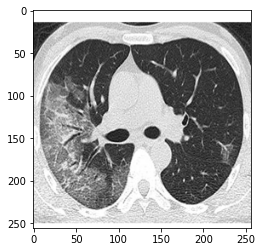

In [34]:
plt.imshow(data_train_x[1])

In [35]:

train_images = data_train_x / 255.0
val_images = data_val_x / 255.0
test_images = data_test_x / 255.0

In [40]:

train_labels = tf.one_hot(train_y, depth=2)
val_labels = tf.one_hot(valid_y, depth=2)
test_labels = tf.one_hot(test_y, depth=2)

In [72]:
base_model = DenseNet169(input_shape=(256,256,3),include_top=False, weights='imagenet')

In [74]:
len(base_model.layers)

595

In [ ]:
tf.keras.utils.plot_model(base_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [75]:
feature_batch = base_model(train_images)
print(feature_batch.shape)

(447, 8, 8, 1664)


In [77]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(447, 1664)


In [78]:
prediction_layer = tf.keras.layers.Dense(2)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(447, 2)


In [79]:
base_model.trainable = True

In [80]:

fine_tune_at = 200

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [81]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [86]:
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
            optimizer=tf.optimizers.Adam(lr=base_learning_rate),
             metrics=['accuracy'])

In [87]:
history = model.fit(train_images, train_labels, epochs=5,validation_data=(val_images,val_labels))

Epoch 1/5
14/14 [==============================] - 6s 456ms/step - loss: 2.4966 - accuracy: 0.5302 - val_loss: 12.7197 - val_accuracy: 1.0000
Epoch 2/5
14/14 [==============================] - 4s 290ms/step - loss: 2.0410 - accuracy: 0.6018 - val_loss: 15.3011 - val_accuracy: 1.0000
Epoch 3/5
14/14 [==============================] - 4s 291ms/step - loss: 1.4914 - accuracy: 0.5973 - val_loss: 15.9689 - val_accuracy: 1.0000
Epoch 4/5
14/14 [==============================] - 4s 291ms/step - loss: 1.8675 - accuracy: 0.6152 - val_loss: 14.9492 - val_accuracy: 1.0000
Epoch 5/5
14/14 [==============================] - 4s 292ms/step - loss: 1.6726 - accuracy: 0.6577 - val_loss: 12.5794 - val_accuracy: 1.0000


In [88]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

5/5 - 0s - loss: 13.2975 - accuracy: 1.0000

Test accuracy: 1.0


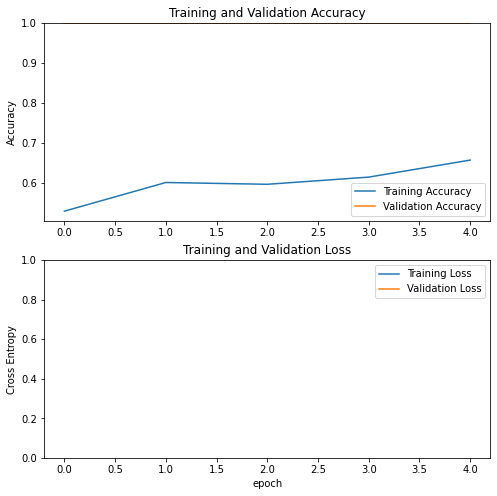

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [90]:
predictions = model.predict(test_images)

In [91]:

test_images[5].shape

(256, 256, 3)

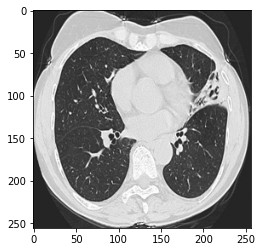

In [92]:
plt.imshow(test_images[5])

In [97]:

class_names[np.argmax(predictions[5])]

'COVID_Positive'

In [98]:

class_names[np.argmax(test_labels[5])]

'COVID_Positive'